## EMMA step 2: Projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing

###  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue.

### - Dynamic read-in: to use this notebook, change the 'site' parameter to "Wade" or "Hugnerford". Tracers and sample filtering will then occur as needed.

### - Event-based PCAs: take as function parameters: site, date range, EM1, EM2, EM3

In [1]:
#####################################
# PCA of streamwater and EMs ########
# Megan E Duffy 07/18/2025 ##########
# Part of EMMA workflow #############
# EVENT SPECIFIC PCA FOR EMMA #######
#####################################

# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define event-specfic PCA plot function

def plot_event_pca(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, using site-specific tracers and selected endmembers.

    Parameters:
        data (DataFrame): Full dataframe containing stream and endmember samples
        site (str): Site name ("Wade" or "Hungerford")
        start_date (str or datetime): Start of storm event (e.g., "2023-04-01")
        end_date (str or datetime): End of storm event (e.g., "2023-04-04")
        endmember_ids (list of str): List of Sample IDs to use as endmembers
        title (str): Title for the plot
    """
    
    # Site-specific tracers
    if site == "Wade":
        tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'Wade' or 'Hungerford'.")

    # Ensure datetime column is datetime type
    data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y", errors="coerce")

    # Subset streamwater in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow"])) &
        (data["Date"] >= pd.to_datetime(start_date)) &
        (data["Date"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA rows for stream, fill NA for endmembers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Date"] = stream["Date"]

    subset_endmembers = endmembers[tracers].copy()
    subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())  # Simple impute
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Date"] = endmembers["Date"].values

    # Combine
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # Scale tracer data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(combined[tracers])

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled)
    combined["PC1"] = pca_result[:, 0]
    combined["PC2"] = pca_result[:, 1]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot streamwater
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Plot endmembers
    endmember_markers = {
        'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        'Groundwater': 'D', 'Baseflow': 'P'
    }
    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e']
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em = combined[(combined["Type"] == etype)]
        if not em.empty:
            ax.scatter(em["PC1"], em["PC2"],
                       marker=endmember_markers[etype], c=color, edgecolors='black',
                       alpha=0.8, s=100, label=etype)
            for _, row in em.iterrows():
                if pd.notnull(row["Date"]):
                    ax.text(row["PC1"], row["PC2"], row["Date"].strftime('%m/%d'), fontsize=8, ha='right')

    ax.set_title(title)
    
    # Variance explained for PC1 and PC2 for axis labels
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100

    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")
    
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

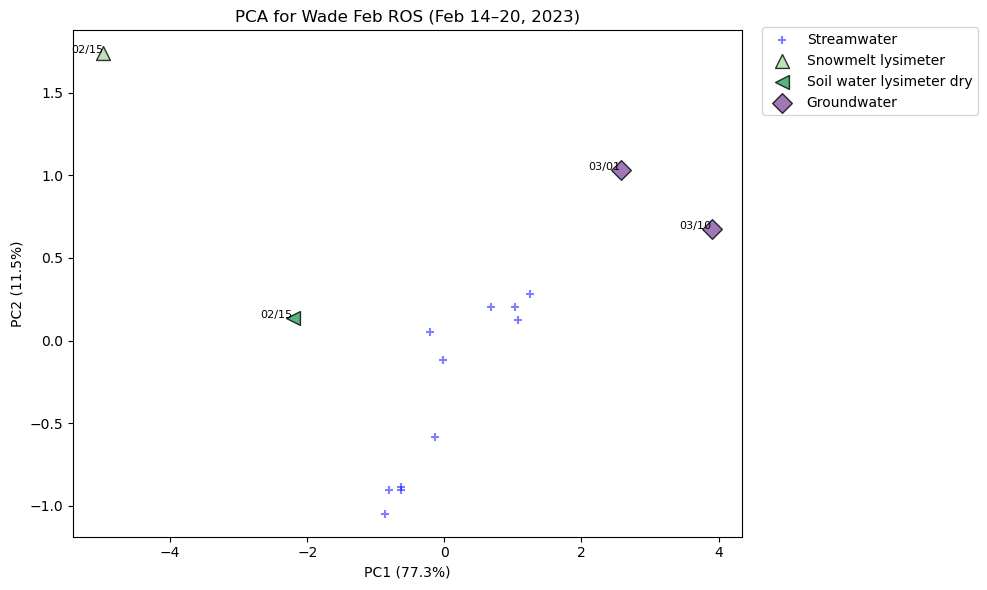

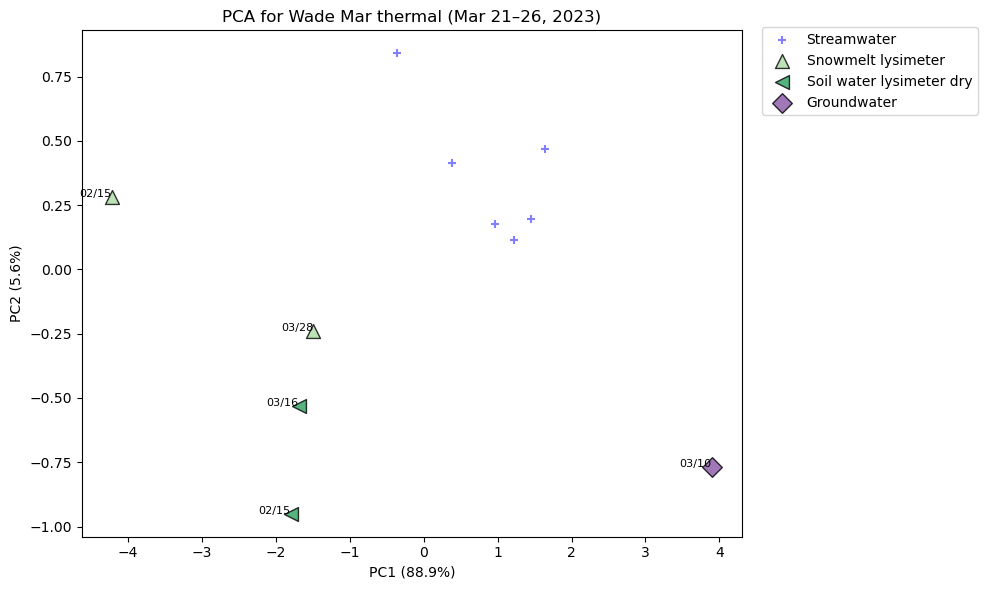

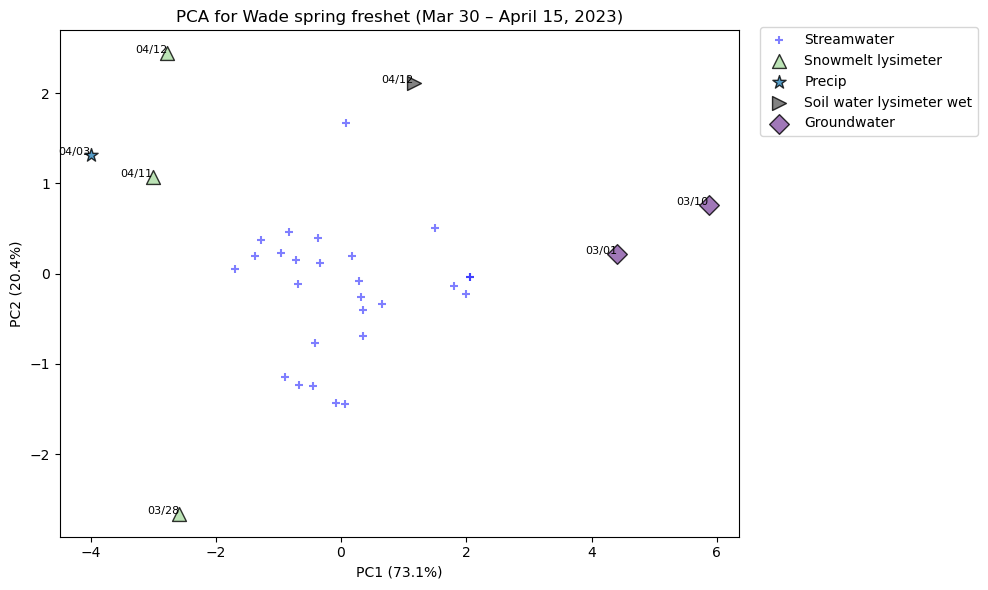

In [2]:
# Load the full RI23 dataset
df = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Feb ROS event
plot_event_pca(
    data=df,
    site="Wade",
    start_date="2023-02-14",
    end_date="2023-02-20",
    endmember_ids=["RI23-5000", "RI23-5005", "RI23-5018", "RI23-5006"],  
    title="PCA for Wade Feb ROS (Feb 14–20, 2023)"
)

# March thermal event
plot_event_pca(
    data=df,
    site="Wade",
    start_date="2023-03-21",
    end_date="2023-03-26",
    endmember_ids=["RI23-5000", "RI23-5005", "RI23-5018", "RI23-5009", "RI23-1063"],  
    title="PCA for Wade Mar thermal (Mar 21–26, 2023)"
)

# Spring freshet
plot_event_pca(
    data=df,
    site="Wade",
    start_date="2023-03-30",
    end_date="2023-04-15",
    endmember_ids=["RI23-5006", "RI23-5018", "RI23-5010", "RI23-1098", "RI23-5011", "RI23-5012", "RI23-1063"],  
    title="PCA for Wade spring freshet (Mar 30 – April 15, 2023)"
)